# Speech Command Recognition 

## Import needed modules

In [1]:
import tensorflow as tf
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import SpeechDownloader
import AudioGen
import speech_model


## Download data from google speech command dataset

In [2]:
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

  0%|          | 6/4868 [00:00<02:25, 33.48it/s]

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files


100%|██████████| 4868/4868 [00:20<00:00, 235.50it/s]


Converting training set WAVs to numpy files


  4%|▎         | 3728/105835 [00:02<01:05, 1556.63it/s]/home/ecbm4040/Project/audioUtils.py:74: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, y = wavfile.read(file)
100%|██████████| 105835/105835 [03:58<00:00, 443.66it/s]


Done preparing Google Speech commands dataset version 2


# Audio Generator

In [3]:
#the default sampling rate for google speech command dataset
sr = 16000
iLen = sr
#We have four sets of dataset: train/val/test/testReal, in which train/val/test are used for training process
#and testReal is used for testing.

#As a result, we need to define 4 generator respectively for each set of data.
trainGen = AudioGen.AudioGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
valGen   = AudioGen.AudioGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)
testGen  = AudioGen.AudioGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = AudioGen.AudioGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))

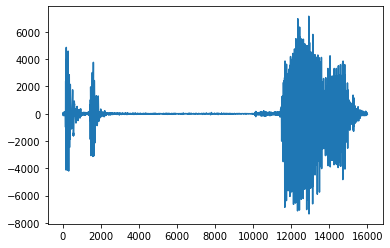

In [4]:
#The __getitem__ method in AudioGen is used to get a batch(32) of data
#The following code is used for check whether the generator works fine
audios_train, classes_train = trainGen.__getitem__(10)
audios_test, classes_test = testGen.__getitem__(15)
classes_train
plt.plot(audios_train[5])

In [5]:
#Before we define our model, we need to test whether our pre-processing of audios works fine.
#To test it, we create a model with keras with two simple layers: 
#One melspectrogram layer and one normalization2D layer. 

from tensorflow.keras.models import Sequential
from spela.melspectrogram import Melspectrogram
from spela.normalisation import Normalization2D
import numpy as np
import soundfile as sf
from scipy.fftpack import dct
import math
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda
import tensorflow.keras.layers

melspecModel = Sequential()
melspecModel.add(Melspectrogram(n_dft=512, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )
melspecModel.add(Normalization2D(int_axis=0))
melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        283728    
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 283,728
Trainable params: 283,728
Non-trainable params: 0
_________________________________________________________________


In [6]:
melspec = melspecModel.predict(audios_train.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

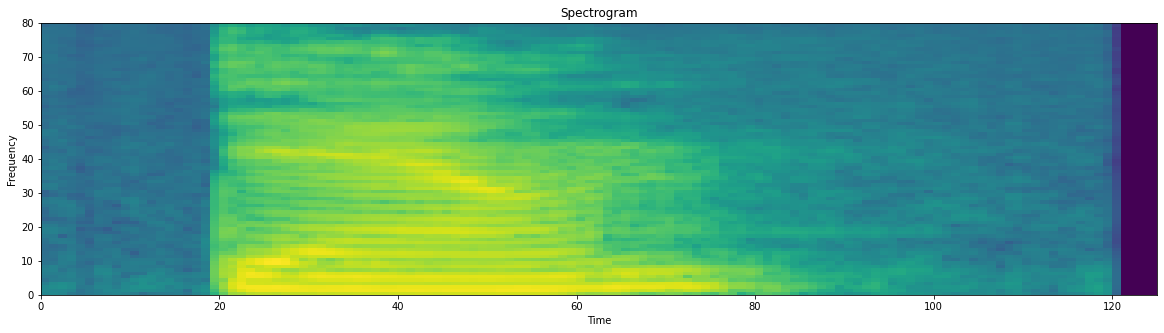

In [7]:
plt.figure(figsize=(20,5))
plt.pcolormesh(melspec[4,:,:,0])

plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

# Models

Create Keras models to see if the generators are working properly

In [8]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from adjust_utils import *

In [9]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model_p1 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p1.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [17]:
# model.load_weights('model-attRNN.h5')

In [10]:
lr_power_1 = LearningRateScheduler(power_decay_1)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_p1 = ModelCheckpoint(filepath='model_attRNN_p1.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results_p1 = model_p1.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_p1, lr_power_1])

model_p1.save('model_attRNN_p1.h5')

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.90957, saving model to model_attRNN_p1.h5
3313/3313 - 509s - loss: 0.6601 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.3172 - val_sparse_categorical_accuracy: 0.9096 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.90957
3313/3313 - 510s - loss: 0.2993 - sparse_categorical_accuracy: 0.9146 - val_loss: 0.4875 - val_sparse_categorical_accuracy: 0.8627 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.90957 to 0.93539, saving model to model_attRNN_p1.h5
3313/3313 - 501s - loss: 0.2311 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.2266 - val_sparse_categorical_accuracy: 0.9354 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy improved from 0.93539 to 0.93780, saving model t

In [14]:
model_p2 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p2.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [17]:
lr_power_2 = LearningRateScheduler(power_decay_2)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_p2 = ModelCheckpoint(filepath='model_attRNN_p2.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_p2 = model_p2.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_p2, lr_power_2])

model_p2.save('model_attRNN_p2.h5')

Changing learning rate to 0.001
Epoch 1/60


KeyboardInterrupt: 

In [15]:
model_e = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_e.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_e.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [16]:
lr_exp = LearningRateScheduler(exp_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_e = ModelCheckpoint(filepath='model_attRNN_e.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_e = model_e.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_e, lr_exp])

model_e.save('model_attRNN_e.h5')

Changing learning rate to 0.0019952623149688794
Epoch 1/60


KeyboardInterrupt: 

In [17]:
model_m = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_m.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [19]:
lr_multi = multi_decay(decay_frac=0.1)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_m = ModelCheckpoint(filepath='model_attRNN_m.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_m = model_m.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_m, lr_multi])

model_e.save('model_attRNN_m.h5')

Epoch 1/60


KeyboardInterrupt: 

In [18]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [19]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.88625, saving model to model-attRNN.h5
2651/2651 - 166s - loss: 0.9273 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.3992 - val_sparse_categorical_accuracy: 0.8863
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.88625 to 0.90555, saving model to model-attRNN.h5
2651/2651 - 141s - loss: 0.3730 - sparse_categorical_accuracy: 0.8936 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.9055
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.90555 to 0.91931, saving model to model-attRNN.h5
2651/2651 - 114s - loss: 0.2874 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.9193
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy improved from 0.91931 to 0.92333, saving model to model-

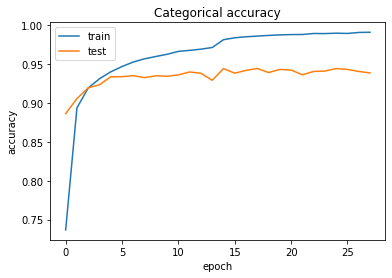

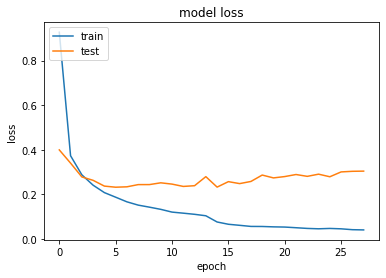

In [20]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# results.history

In [22]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [23]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [24]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.050812821835279465, 0.9879997968673706] 
Validation: [0.25880271196365356, 0.9434284567832947] 
Test: [0.2511102557182312, 0.9385733604431152]


In [25]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [26]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [27]:
audios, classes = valGen.__getitem__(3)
classes

array([ 5,  7, 11, 24, 17, 12, 20, 10, 11, 18, 17,  1, 31, 11,  4, 26, 22,
       17,  5,  6, 17, 16,  7, 28,  4, 22, 27, 33,  4,  6, 33,  5])

In [28]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

11

In [29]:
outs, attW, specs = attSpeechModel.predict(audios)

In [30]:
np.argmax(outs,axis=1)

array([ 5,  7, 11, 24, 17, 12, 20, 10, 35, 18, 26,  1, 31, 11,  4, 26, 22,
       17,  5,  6, 17, 16,  7, 28,  4, 22, 16, 33,  4,  6, 33,  5])

In [31]:
specs.shape

(32, 80, 125, 1)

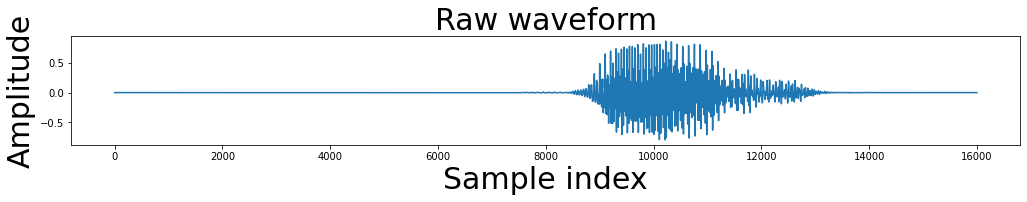

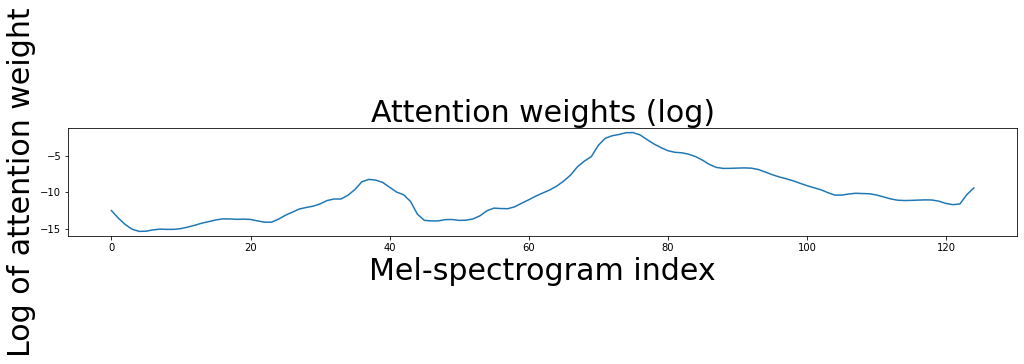

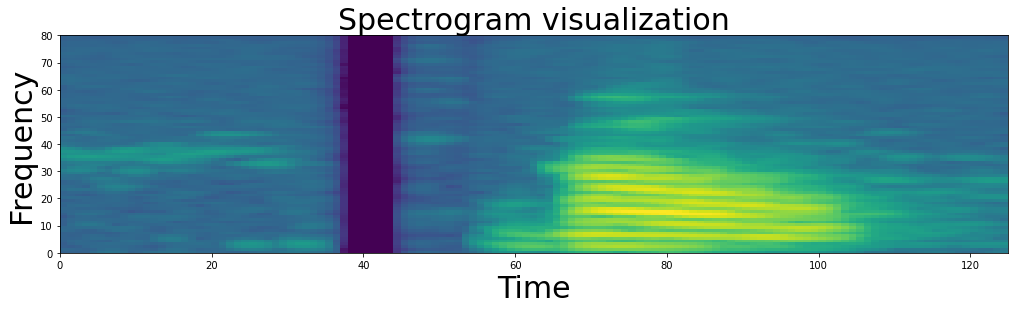

In [32]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [33]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 5s 14ms/step


In [34]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [35]:
#set(y_test)

In [36]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [37]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [38]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


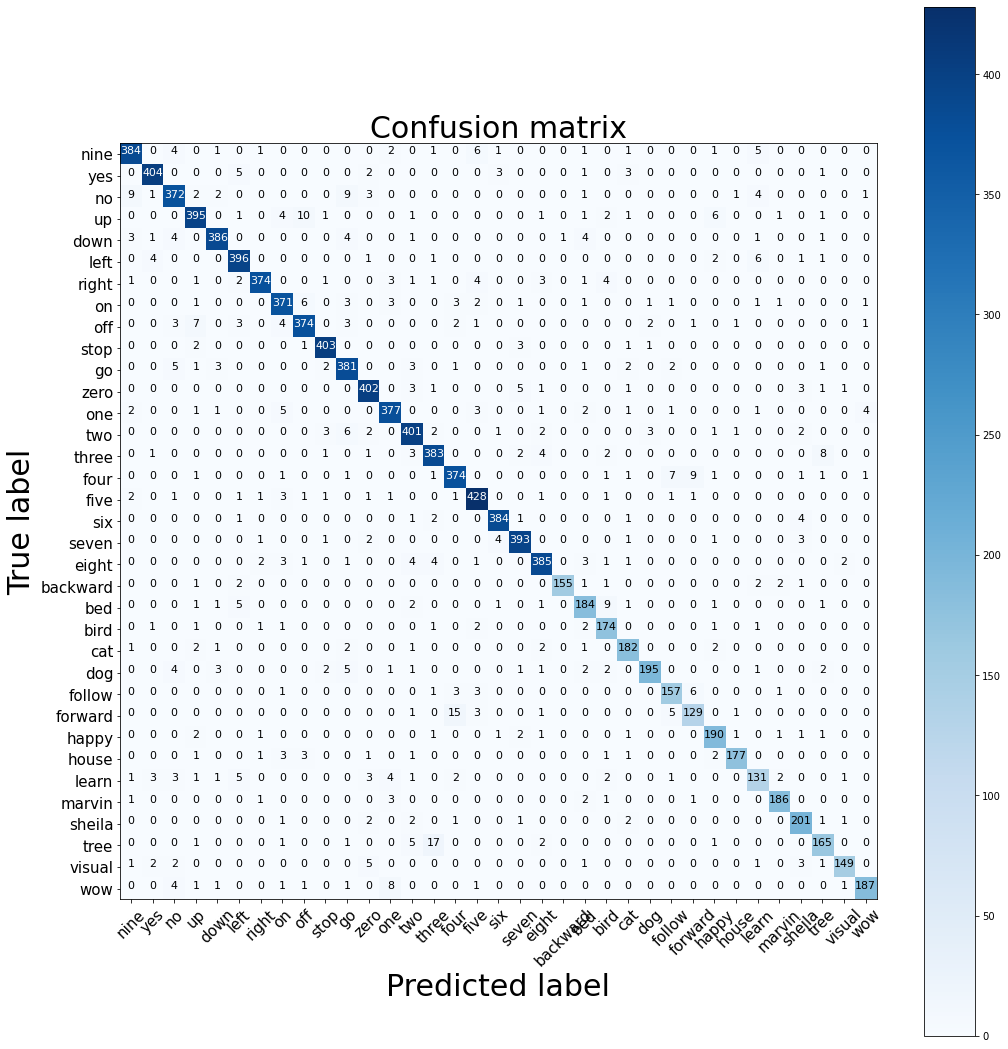

In [39]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [40]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.3.0', '0.2.0', '1.0.5', '0.8.0']

# Save model to .pb

In [48]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights('model-attRNN.h5')

model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [42]:
tf.saved_model.save(model, "attRNNModel/1/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: attRNNModel/1/assets


In [43]:
import os
os.listdir('attRNNModel/1/')

['assets', 'saved_model.pb', 'variables']

In [44]:
# if using tensorflow 1.x

In [45]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [49]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

#frozen_graph = freeze_session(sess,
#                              output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)